# Experimental randomness from quantum inputs

## Experimental Parameters (including losses)

In [44]:
p0 = 0.6065;
p1 = 0.3032;
p2 = 0.0758;

psum = p0+p1+p2;
p0 = p0/psum;
p1 = p1/psum;
p2 = p2/psum;

Probability distribution:
The events are $a = \{\emptyset, 0, 1, 2, 3, 01, 02, 03, 12, 13, 23\}$. 
where the modes are labelled $0$ - $3$, and $\emptyset$ signifies no-click.

In [46]:
oa = 11; % number of outcomes
ma = 5; % number of states;

Pax = zeros(oa,ma);

for x = 1:ma
    Pax(1,x) = p0; % no click probability
end

for x = 1:4
    Pax(x+1,x) = p1+p2;
end

for a = 2:5
    Pax(a,5) = p1/4 + p2/28;
end

for a = 6:11
    Pax(a,5) = 4*p2/28;
end

Pax
sum(Pax,1)

Pax =
    0.6154    0.6154    0.6154    0.6154    0.6154
    0.3846         0         0         0    0.0797
         0    0.3846         0         0    0.0797
         0         0    0.3846         0    0.0797
         0         0         0    0.3846    0.0797
         0         0         0         0    0.0110
         0         0         0         0    0.0110
         0         0         0         0    0.0110
         0         0         0         0    0.0110
         0         0         0         0    0.0110
         0         0         0         0    0.0110
ans =
     1     1     1     1     1


Input states:

In [4]:
d = 15;
kets = eye(d);
omegax = zeros(d,d,ma);

omegax(:,:,1) = p0*kets(:,1)*kets(1,:) + p1*kets(:,2)*kets(2,:) + p2*kets(:,6)*kets(6,:);
omegax(:,:,2) = p0*kets(:,1)*kets(1,:) + p1*kets(:,3)*kets(3,:) + p2*kets(:,7)*kets(7,:);
omegax(:,:,3) = p0*kets(:,1)*kets(1,:) + p1*kets(:,4)*kets(4,:) + p2*kets(:,8)*kets(8,:);
omegax(:,:,4) = p0*kets(:,1)*kets(1,:) + p1*kets(:,5)*kets(5,:) + p2*kets(:,9)*kets(9,:);

chi = 1/2*(1i*kets(:,2) + kets(:,3) -1i*kets(:,4) + kets(:,5));
chi2 = (-kets(:,6)+kets(:,7)-kets(:,8)+kets(:,9)+2*1i*kets(:,15)+2*kets(:,14)+2*1i*kets(:,13)-2*1i*kets(:,12)+2*kets(:,11)-2*1i*kets(:,10));
chi2 = chi2/sqrt(trace(chi2*chi2'));

omegax(:,:,5) = p0*kets(:,1)*kets(1,:) + p1*chi*chi' + p2*chi2*chi2';

### SDP based on full data

In [6]:
xs = 5;

cvx_begin sdp quiet

    variable Nae(d,d,oa,oa) hermitian semidefinite
    variable qe(oa) nonnegative
    
    dual variables Iax{oa-1,ma}
    dual variables Xa{oa}
    dual variable nu
    
    maximise real(sumall(conj(repmat(omegax(:,:,xs),[1,1,oa,oa])).*Nae.*...
        permute(repmat(eye(oa),[1,1,d,d]),[3,4,1,2])))
    
    for a = 1:oa-1
        for x = 1:ma
            Iax{a,x} : Pax(a,x) == trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x))
        end
    end
    
    
    for e = 1:oa
        Xa{e} : sum(Nae(:,:,:,e),3) == qe(e)*eye(d)
    end
    
    nu : sum(qe) == 1
    
cvx_end

Iax = cell2mat(Iax);

Pgfull = cvx_optval
Hminfull = -log2(Pgfull)

Pgfull =
    0.6154
Hminfull =
    0.7003


### Extract inequality

In [12]:
Iaxp = [Iax; zeros(1,ma)]; %make it the same dimension as Pax
Iaxp(1:5,1:4) = Iaxp(1:5,1:4) - Iaxp(3,1); %set 'off-diagonal' terms equal to zero (in the zero+one photon subspaces)
Iaxp = Iaxp/Iaxp(2,1); % make the diagonal elements (in the one photon subspace) equal to one

Iaxp = round(1E3*Iaxp)/1E3 % round the result

Iaxp =
    0.7180    0.7180    0.7180    0.7180   -0.9510
    1.0000         0         0         0         0
         0    1.0000         0         0         0
         0         0    1.0000         0         0
         0         0         0    1.0000         0
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0


### SDP based upon functional $I_{ax}$

In [14]:
cvx_begin sdp quiet

    variable Nae(d,d,oa,oa) hermitian semidefinite
    variable qe(oa) nonnegative
    
    expression beta
    
    maximise real(sumall(conj(repmat(omegax(:,:,xs),[1,1,oa,oa])).*Nae.*...
        permute(repmat(eye(oa),[1,1,d,d]),[3,4,1,2])))
    
    beta = 0;
    for a = 1:oa
        for x = 1:ma
            beta = beta + Iaxp(a,x)*trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x));
        end
    end
    
    beta == sumall(Iaxp.*Pax)
    
    for e = 1:oa
        sum(Nae(:,:,:,e),3) == qe(e)*eye(d)
    end
    
    sum(qe) == 1
    
cvx_end

PgI = cvx_optval
HminI = -log2(PgI)

PgI =
    0.6154
HminI =
    0.7003


We see that we obtain the same amount of randomness from the simple functional above.

Unfortunately I don't know have analytic expressions for the two parameters $I_{\emptyset,x}$ for $x \in \{0,1,2,3\}$ and $x = 5$. 

## Post-selecting (ignoring no-click events)

In [37]:
p0 = 0;
p1 = 0.3032;
p2 = 0.0758;

psum = p1+p2;
p1 = p1/psum;
p2 = p2/psum;

Probability distribution:
The events are $a = \{0, 1, 2, 3, 01, 02, 03, 12, 13, 23\}$. 
where the modes are labelled $0$ - $3$,

In [38]:
oa = 10; % number of outcomes
ma = 5; % number of states;

Pax = zeros(oa,ma);

for x = 1:4
    Pax(x,x) = p1+p2;
end

for a = 1:4
    Pax(a,5) = p1/4 + p2/28;
end

for a = 5:10
    Pax(a,5) = 4*p2/28;
end

Pax
sum(Pax,1)

delta = 0.999;

Paxd = delta*Pax + (1-delta)*ones(oa,ma)/oa

Pax =
    1.0000         0         0         0    0.2071
         0    1.0000         0         0    0.2071
         0         0    1.0000         0    0.2071
         0         0         0    1.0000    0.2071
         0         0         0         0    0.0286
         0         0         0         0    0.0286
         0         0         0         0    0.0286
         0         0         0         0    0.0286
         0         0         0         0    0.0286
         0         0         0         0    0.0286
ans =
     1     1     1     1     1
Paxd =
    0.9991    0.0001    0.0001    0.0001    0.2070
    0.0001    0.9991    0.0001    0.0001    0.2070
    0.0001    0.0001    0.9991    0.0001    0.2070
    0.0001    0.0001    0.0001    0.9991    0.2070
    0.0001    0.0001    0.0001    0.0001    0.0286
    0.0001    0.0001    0.0001    0.0001    0.0286
    0.0001    0.0001    0.0001    0.0001    0.0286
    0.0001    0.0001    0.0001    0.0001    0.0286
    0.0001    0.0001    0.0001  

Input states:

In [40]:
da = 15;
kets = eye(da);
omegax = zeros(da,da,ma);

omegax(:,:,1) = p0*kets(:,1)*kets(1,:) + p1*kets(:,2)*kets(2,:) + p2*kets(:,6)*kets(6,:);
omegax(:,:,2) = p0*kets(:,1)*kets(1,:) + p1*kets(:,3)*kets(3,:) + p2*kets(:,7)*kets(7,:);
omegax(:,:,3) = p0*kets(:,1)*kets(1,:) + p1*kets(:,4)*kets(4,:) + p2*kets(:,8)*kets(8,:);
omegax(:,:,4) = p0*kets(:,1)*kets(1,:) + p1*kets(:,5)*kets(5,:) + p2*kets(:,9)*kets(9,:);

chi = 1/2*(1i*kets(:,2) + kets(:,3) -1i*kets(:,4) + kets(:,5));
chi2 = (-kets(:,6)+kets(:,7)-kets(:,8)+kets(:,9)+2*1i*kets(:,15)+2*kets(:,14)+2*1i*kets(:,13)-2*1i*kets(:,12)+2*kets(:,11)-2*1i*kets(:,10));
chi2 = chi2/sqrt(trace(chi2*chi2'));

omegax(:,:,5) = p0*kets(:,1)*kets(1,:) + p1*chi*chi' + p2*chi2*chi2';

### SDP based on full data

In [41]:
xs = 5;

cvx_begin sdp quiet

    variable Nae(da,da,oa,oa) hermitian semidefinite
    variable qe(oa) nonnegative
    
    dual variables Iax{oa-1,ma}
    dual variables Xa{oa}
    dual variable nu
    
    maximise real(sumall(conj(repmat(omegax(:,:,xs),[1,1,oa,oa])).*Nae.*...
        permute(repmat(eye(oa),[1,1,da,da]),[3,4,1,2])))
    
    for a = 1:oa-1
        for x = 1:ma
            Iax{a,x} : Paxd(a,x) == trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x))
        end
    end
    
    
    for e = 1:oa
        Xa{e} : sum(Nae(:,:,:,e),3) == qe(e)*eye(da)
    end
    
    nu : sum(qe) == 1
    
cvx_end

Iax = cell2mat(Iax);

cvx_optval
-log2(cvx_optval)

Pfgull = sumall(Iax.*Pax(1:oa-1,:)) - nu
Hminfull = -log2(Pfgull)

cvx_optval =
    0.2371
ans =
    2.0762
Pfgull =
    0.2233
Hminfull =
    2.1630


### Extract inequality

In [42]:
Iaxp = [Iax; zeros(1,ma)] %make it the same dimension as Pax
Iaxp(1:4,1:4) = Iaxp(1:4,1:4) - Iaxp(3,1); %set 'off-diagonal' terms equal to zero (in the zero+one photon subspaces)
Iaxp = Iaxp/Iaxp(1,1); % make the diagonal elements (in the one photon subspace) equal to one

Iaxp = round(1E5*Iaxp)/1E5 % round the result

Iaxp =
   -1.8445    6.3537    6.3537    6.3537    0.9793
    6.3537   -1.8445    6.3537    6.3537    0.9793
    6.3537    6.3537   -1.8445    6.3537    0.9793
    6.3537    6.3537    6.3537   -1.8445    0.9793
   -0.0000   -0.0000   -0.0000   -0.0000    0.0000
   -0.0000   -0.0000   -0.0000   -0.0000    0.0000
   -0.0000   -0.0000   -0.0000   -0.0000    0.0000
   -0.0000   -0.0000   -0.0000   -0.0000    0.0000
   -0.0000   -0.0000   -0.0000   -0.0000    0.0000
         0         0         0         0         0
Iaxp =
    1.0000         0         0         0   -0.1195
         0    1.0000         0         0   -0.1195
         0         0    1.0000         0   -0.1195
         0         0         0    1.0000   -0.1195
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0
         0       

### SDP based upon functional $I_{ax}$

In [58]:
alpha = 0.1

Iax = zeros(oa,ma);
Iax(1:4,1:4) = eye(4);
Iax(1:4,5) = -alpha*ones(1,4);

betaobs = sumall(Iax.*Pax)

cvx_begin sdp quiet

    variable Nae(da,da,oa,oa) hermitian semidefinite
    variable qe(oa) nonnegative
    
    expression beta
    
    maximise real(sumall(conj(repmat(omegax(:,:,xs),[1,1,oa,oa])).*Nae.*...
        permute(repmat(eye(oa),[1,1,da,da]),[3,4,1,2])))
    
    beta = 0;
    for a = 1:oa
        for x = 1:ma
            beta = beta + Iax(a,x)*trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x));
        end
    end
    
    beta == sumall(Iax.*Pax)
    
    for e = 1:oa
        sum(Nae(:,:,:,e),3) == qe(e)*eye(da)
    end
    
    sum(qe) == 1
    
cvx_end

PgI = cvx_optval
HminI = -log2(PgI)

alpha =
    0.1000
betaobs =
    3.9171
PgI =
    0.2147
HminI =
    2.2199


Now we obtain slightly less randomness, but still a comparable amount, with a simple functional

### Study of $I_{ax}(\alpha)$ functionals

In [4]:
p0 = 0;
p1 = 0.3032;
p2 = 0.0758;

psum = p0+p1+p2;
p1 = p1/psum;
p2 = p2/psum;

Input states:

In [7]:
da = 15;
ma = 5;

kets = eye(da);
omegax = zeros(da,da,ma);

omegax(:,:,1) = p0*kets(:,1)*kets(1,:) + p1*kets(:,2)*kets(2,:) + p2*kets(:,6)*kets(6,:);
omegax(:,:,2) = p0*kets(:,1)*kets(1,:) + p1*kets(:,3)*kets(3,:) + p2*kets(:,7)*kets(7,:);
omegax(:,:,3) = p0*kets(:,1)*kets(1,:) + p1*kets(:,4)*kets(4,:) + p2*kets(:,8)*kets(8,:);
omegax(:,:,4) = p0*kets(:,1)*kets(1,:) + p1*kets(:,5)*kets(5,:) + p2*kets(:,9)*kets(9,:);

chi = 1/2*(1i*kets(:,2) + kets(:,3) -1i*kets(:,4) + kets(:,5));
chi2 = (-kets(:,6)+kets(:,7)-kets(:,8)+kets(:,9)+2*1i*kets(:,15)+2*kets(:,14)+2*1i*kets(:,13)-2*1i*kets(:,12)+2*kets(:,11)-2*1i*kets(:,10));
chi2 = chi2/sqrt(trace(chi2*chi2'));

omegax(:,:,5) = p0*kets(:,1)*kets(1,:) + p1*chi*chi' + p2*chi2*chi2';

#### SDP based upon functional $I_{ax}$

In [14]:
%%file MDIRandomnessIneq.m

function Pg = MDIRandomnessIneq(Iax,betaobs,omegax)

[oa,ma] = size(Iax);
[da,~,~] = size(omegax);

xs = 5;

cvx_begin sdp quiet

    variable Nae(da,da,oa,oa) hermitian semidefinite
    variable qe(oa) nonnegative
    
    expression beta
    
    maximise real(sumall(conj(repmat(omegax(:,:,xs),[1,1,oa,oa])).*Nae.*...
        permute(repmat(eye(oa),[1,1,da,da]),[3,4,1,2])))
    
    beta = 0;
    for a = 1:oa
        for x = 1:ma
            beta = beta + Iax(a,x)*trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x));
        end
    end
    
    beta == betaobs
    
    for e = 1:oa
        sum(Nae(:,:,:,e),3) == qe(e)*eye(da)
    end
    
    sum(qe) == 1
    
cvx_end

Pg = cvx_optval;

end

Created file '/home/phyps/git/MDI-randomness/MDIRandomnessIneq.m'.


In [53]:
oa = 10;
ma = 5;
da = 15;

eps = 1E-5;
nsteps = 51;

alphav = [1E-5 1E-4 1E-3 1E-2 1E-1];
nalpha = length(alphav);

betav = zeros(nalpha,nsteps);
Hminv = zeros(nalpha,nsteps);

for k = 1:nalpha

    alpha = alphav(k);
    Iax = zeros(oa,ma);
    Iax(1:4,1:4) = eye(4);
    Iax(1:4,5) = -alpha*ones(1,4);

    cvx_begin sdp quiet

        variable Ma(da,da,oa) hermitian semidefinite
    
        expression beta
    
        beta = 0;
        for a = 1:oa
            for x = 1:ma
                beta = beta + Iax(a,x)*trace(Ma(:,:,a)*omegax(:,:,x));
            end
        end
    
        maximise beta
    
        sum(Ma,3) == eye(da)
    
    cvx_end

    Iaxmax = cvx_optval

    cvx_begin sdp quiet

        variable Nae(da,da,oa,oa) hermitian semidefinite
        variable qe(oa) nonnegative
    
        expression beta
    
        beta = 0;
        for a = 1:oa
            for x = 1:ma
                beta = beta + Iax(a,x)*trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x));
            end
        end
    
        maximise beta
    
        sumall(conj(repmat(omegax(:,:,5),[1,1,oa,oa])).*Nae.*...
            permute(repmat(eye(oa),[1,1,da,da]),[3,4,1,2])) == 1
    
        for e = 1:oa
            sum(Nae(:,:,:,e),3) == qe(e)*eye(da)
        end
    
        sum(qe) == 1
    
    cvx_end

    Iaxmin = cvx_optval

    betav(k,:) = linspace(Iaxmin,Iaxmax-eps,nsteps);

    for i = 1:nsteps
        betaobs = betav(k,i);
        Pg = MDIRandomnessIneq(Iax,betaobs,omegax);
        Hminv(k,i) = -log2(Pg);
    end
end

Iaxmax =
    4.0000
Iaxmin =
    2.7780
Iaxmax =
    3.9999
Iaxmin =
    2.7779
Iaxmax =
    3.9992
Iaxmin =
    2.7770
Iaxmax =
    3.9917
Iaxmin =
    2.7679
Iaxmax =
    3.9174
Iaxmin =
    2.6780


Current plot held


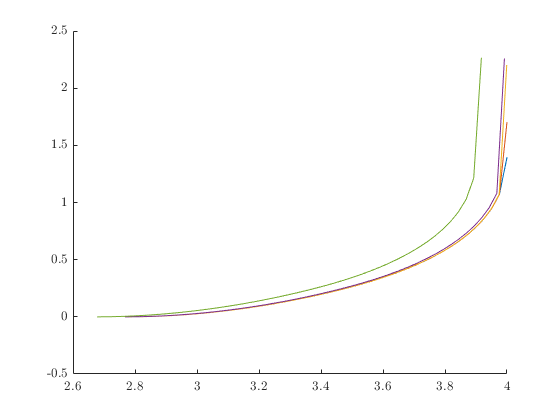

In [55]:
figure
hold
for k = 1:nalpha
    plot(betav(k,:),Hminv(k,:))
end

### $\beta_c$ in order to get $\log(3)$ bits of randomness, as a function of $\alpha$

In [61]:
oa = 10;
ma = 5;
da = 15;

nalpha = 11;
alphav = linspace(0,0.5,nalpha);


betacv = zeros(1,nalpha);

for k = 1:nalpha

    alpha = alphav(k);
    Iax = zeros(oa,ma);
    Iax(1:4,1:4) = eye(4);
    Iax(1:4,5) = -alpha*ones(1,4);

    cvx_begin sdp quiet

        variable Nae(da,da,oa,oa) hermitian semidefinite
        variable qe(oa) nonnegative
    
        expression beta
    
        beta = 0;
        for a = 1:oa
            for x = 1:ma
                beta = beta + Iax(a,x)*trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x));
            end
        end
    
        maximise beta
    
        sumall(conj(repmat(omegax(:,:,5),[1,1,oa,oa])).*Nae.*...
            permute(repmat(eye(oa),[1,1,da,da]),[3,4,1,2])) == 1/3
    
        for e = 1:oa
            sum(Nae(:,:,:,e),3) == qe(e)*eye(da)
        end
    
        sum(qe) == 1
    
    cvx_end

    betacv(k) = cvx_optval;

end

betacv =
  Columns 1 through 7
    4.0000         0         0         0         0         0         0
  Columns 8 through 11
         0         0         0         0
betacv =
  Columns 1 through 7
    4.0000    3.9525         0         0         0         0         0
  Columns 8 through 11
         0         0         0         0
betacv =
  Columns 1 through 7
    4.0000    3.9525    3.9055         0         0         0         0
  Columns 8 through 11
         0         0         0         0
betacv =
  Columns 1 through 7
    4.0000    3.9525    3.9055    3.8589         0         0         0
  Columns 8 through 11
         0         0         0         0
betacv =
  Columns 1 through 7
    4.0000    3.9525    3.9055    3.8589    3.8128         0         0
  Columns 8 through 11
         0         0         0         0
betacv =
  Columns 1 through 7
    4.0000    3.9525    3.9055    3.8589    3.8128    3.7673         0
  Columns 8 through 11
         0         0         0         0
beta

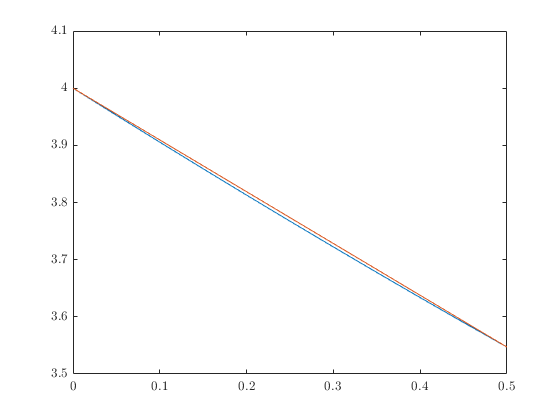

In [63]:
plot(alphav,betacv,[alphav(1),alphav(end)],[betacv(1),betacv(end)])

In [64]:
[alphav' betacv']

ans =
         0    4.0000
    0.0500    3.9525
    0.1000    3.9055
    0.1500    3.8589
    0.2000    3.8128
    0.2500    3.7673
    0.3000    3.7222
    0.3500    3.6776
    0.4000    3.6336
    0.4500    3.5900
    0.5000    3.5470
